In [1]:
import os
import sys

# Get the current working directory and add the parent directory to the Python path
current_working_directory = os.getcwd()
print(os.path.join(current_working_directory, ".."))
sys.path.append(os.path.join(current_working_directory, ".."))

/Users/L024258/lilly_work/github-copilot/exploration/langgraph/..


In [2]:
import pprint

### Defining the Graph state

In [3]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from IPython.display import Image, display

In [4]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_step: Annotated[list, operator.add]

In [5]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults

pubmed_search = PubmedQueryRun()
arxiv_search = ArxivQueryRun()
tavily_tool = TavilySearchResults(max_results=5)

# tools = [arxiv_search, pubmed_search, tavily_tool]
tools = [arxiv_search, pubmed_search]
tools = [arxiv_search]

In [6]:
from models.llm import LLM

model = LLM('gpt-4o-mini')
llm = model.load_model()

In [25]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def research_agent(data):
    print("----research node----")
    print(data)
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI research assistant,"
                " Use the appropriate search tools to progress towards finding the relevant results."
                " Once you have the relevant search results, summarise them to answer the user query."
                "\nYou have access to the following search tools: {tool_names}."
            ),
            (
                "human",
                "\nUser Query: {input}"
            ),
            
            MessagesPlaceholder(variable_name="intermediate_step"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    print(prompt)
    agent = prompt | llm.bind_tools(tools)
    result = agent.invoke(data)
    return {'agent_outcome': [result]}

In [26]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(AgentState)

workflow.add_node("research", research_agent)
workflow.set_entry_point("research")

In [27]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("----tool calling----")
        message = inputs["agent_outcome"][-1]

        outputs = []
        for tool_call in message.tool_calls:
            print(f"---- {tool_call['name']} ----")
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {
                "agent_outcome": outputs,
                "intermediate_step": [str(outputs)]
            }

tool_node = BasicToolNode(tools=tools)
workflow.add_node("tools", tool_node)

In [28]:
def route_tools(
    state: AgentState,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    print("----router----")
    print(state)
    if isinstance(state, list):
        ai_message = state[-1]
    elif agent_outcome := state.get("agent_outcome", []):
        ai_message = agent_outcome[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    print(ai_message)

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [29]:
workflow.add_conditional_edges(
    "research",
    route_tools,
    {"tools": "tools", END: END}
)

In [30]:
workflow.add_edge("tools", "research")

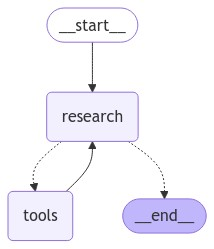

In [31]:
app = workflow.compile()
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
inputs = {
    "input": "What are the recent papers on Small Language Models?",
}

state = AgentState(**inputs)
for s in app.stream(input=state):
    pprint.pp(s)
    print(list(s.values())[0]['agent_outcome'][0].content)
    print("-----"*20)

----research node----
{'input': 'What are the recent papers on Small Language Models?', 'intermediate_step': []}
input_variables=['input', 'intermediate_step'] input_types={'intermediate_step': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'tool_names': 'arxiv'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['tool_names'], template='You are a helpful AI research assistant, Use the appropriate search tools to progress towards finding the relevant results. Once you have the relevant search results, summarise them to answer the user query.\nYou have access to the following search tools: {tool_names}.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='\nUser Query:

<function dict.values>